       Y    X    F3    F4    P7   FC6    F7    F8    T7    P8   FC5   AF4  \
0     37 -105  3158 -5979 -3390 -8020  7459  6436  4312  2258  4944  2915   
2    131   82  8147  7673  5630  7034  5582 -5772  5180 -3089 -2594  6834   
4    116  101 -2841 -5173  2412  3962   647  6063  5570   344 -8010  1954   
6    145  -60  6092  1465  3586 -7266 -4215  5772  3682 -6190 -3466  2997   
8    -86  -39 -2033  5538  6293 -2784   806  7422  2278  -659 -6838  7158   
10    59  119  2605  3572  2733  7307 -6038  -594  6492  5720 -2940  7272   
12   -11  119  3604 -3073 -5901  4010 -2381  5149  4187  1298  7974 -5292   
14   -86   80  2406   329 -3775 -2767  -889   295  -548 -2392 -1621  6645   
16    95   95 -3339 -5359  2184 -2226  6089  -317  6776 -4372  3617  6968   
18     2  -29  7642  -535 -6334  3350 -1433 -4435 -1461 -7367 -6794 -2826   
20   -35    0  7698 -6167  6937 -1713  7314 -1456  6642 -2041   673  -929   
22  -100  -10  5495  3954 -7551 -6101  3330 -5532 -3794  5053 -1379  4258   

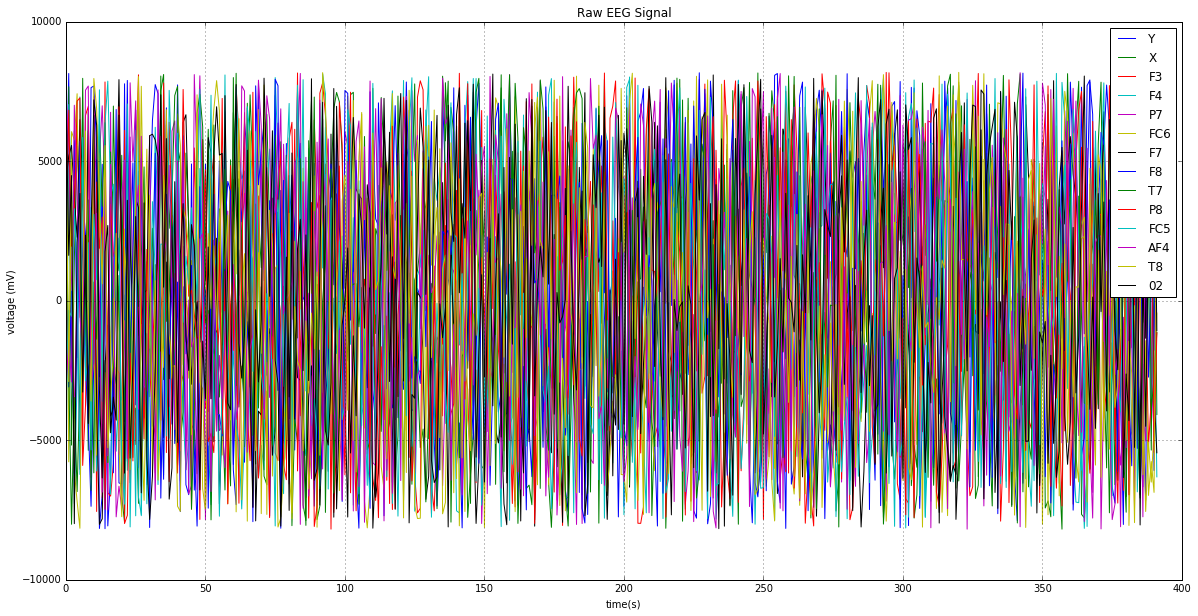

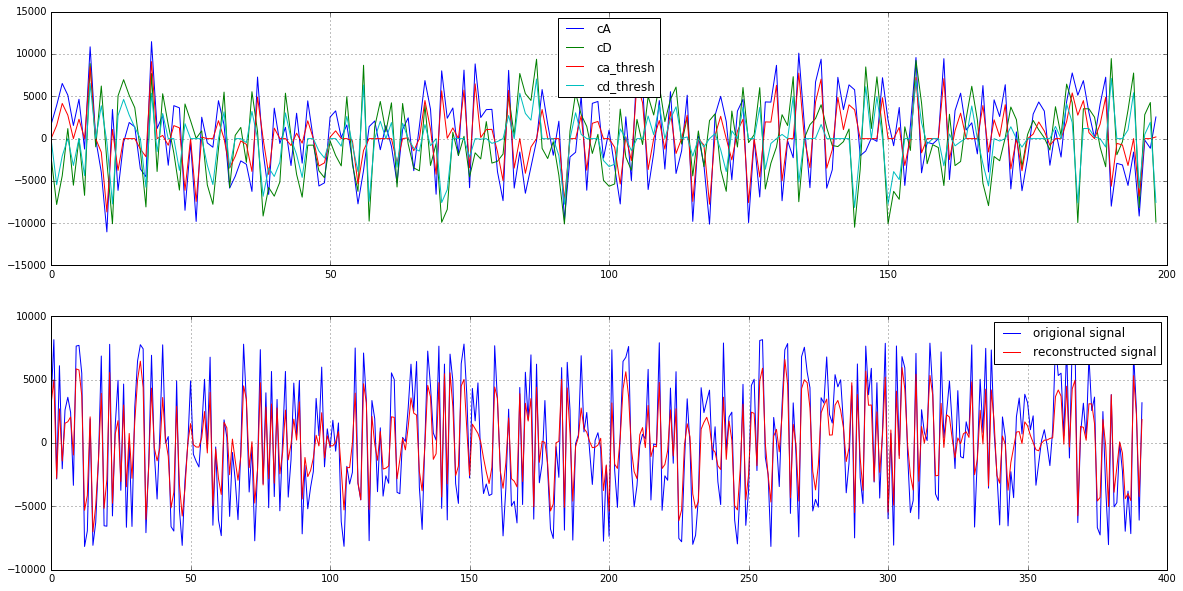

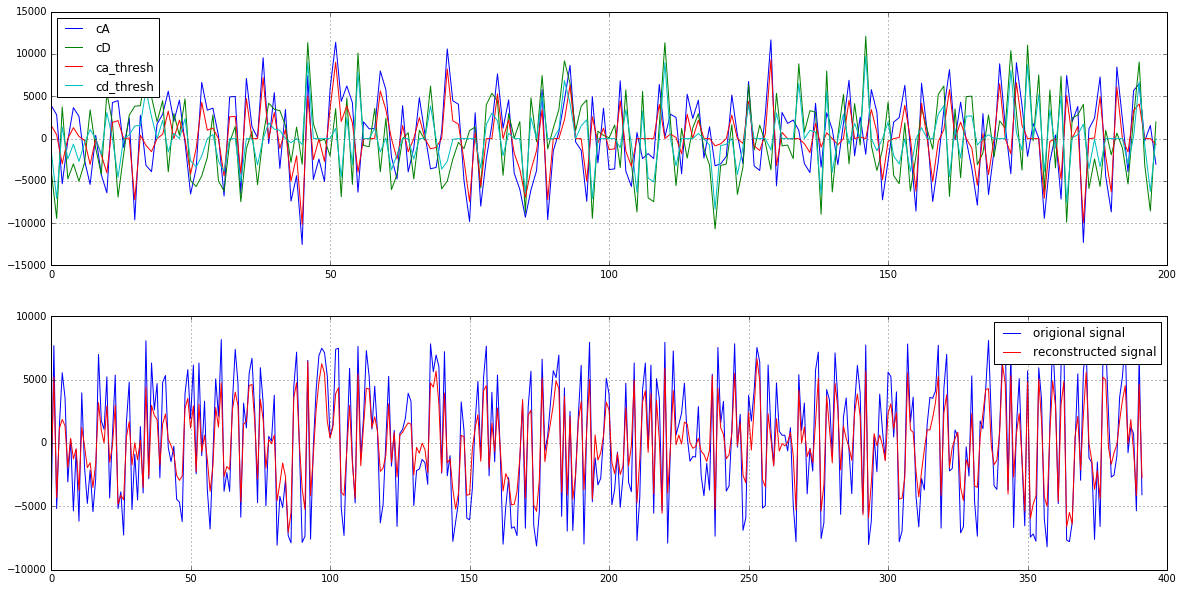

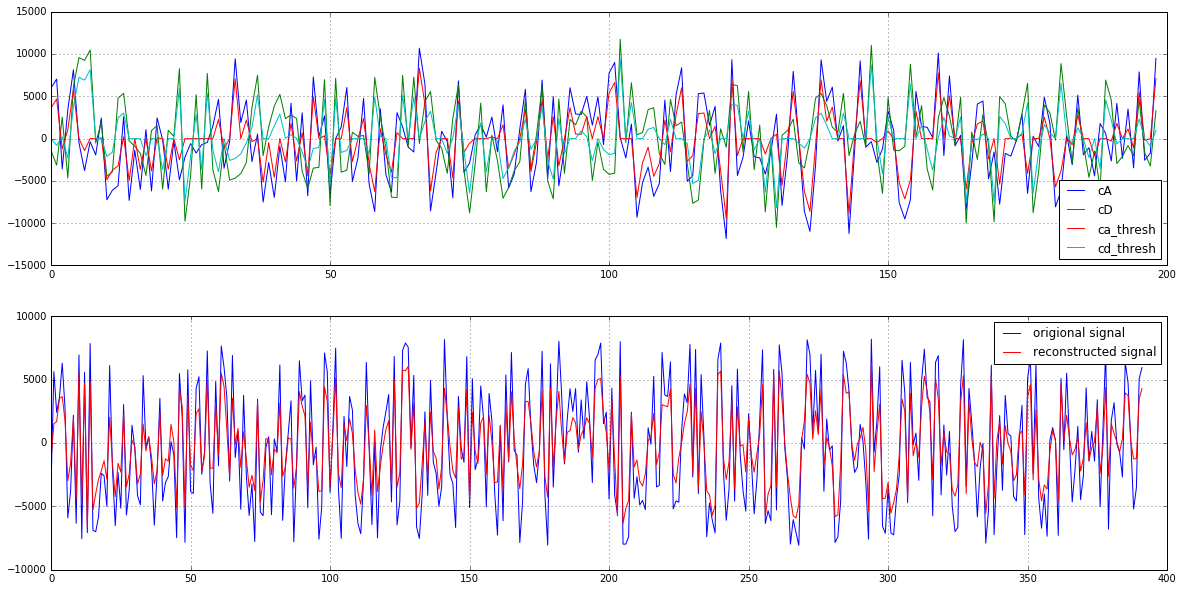

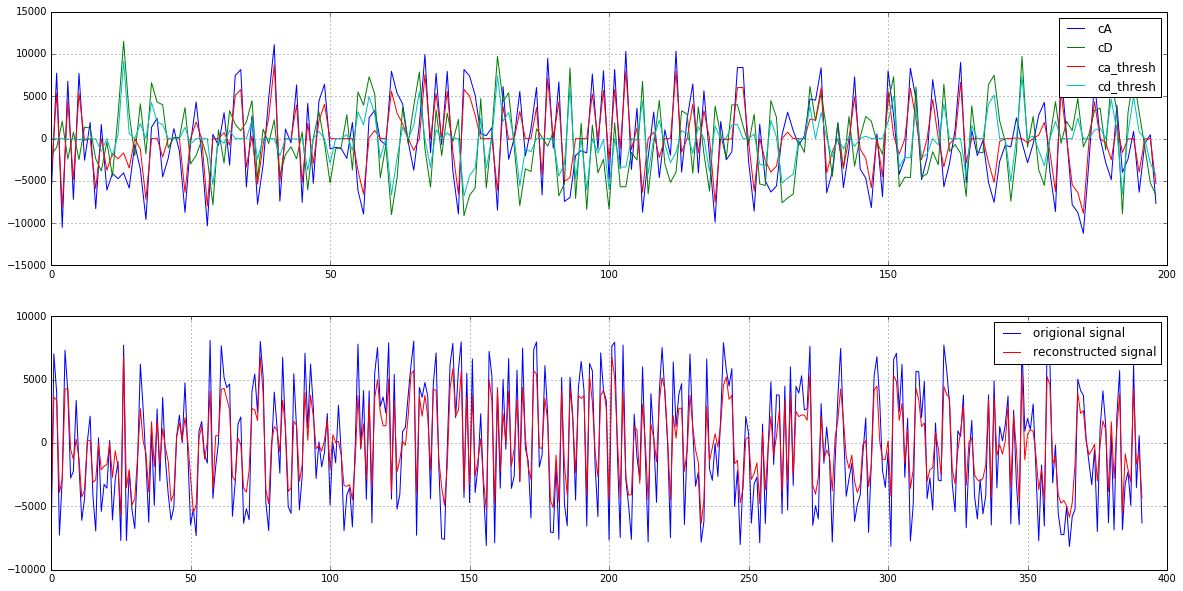

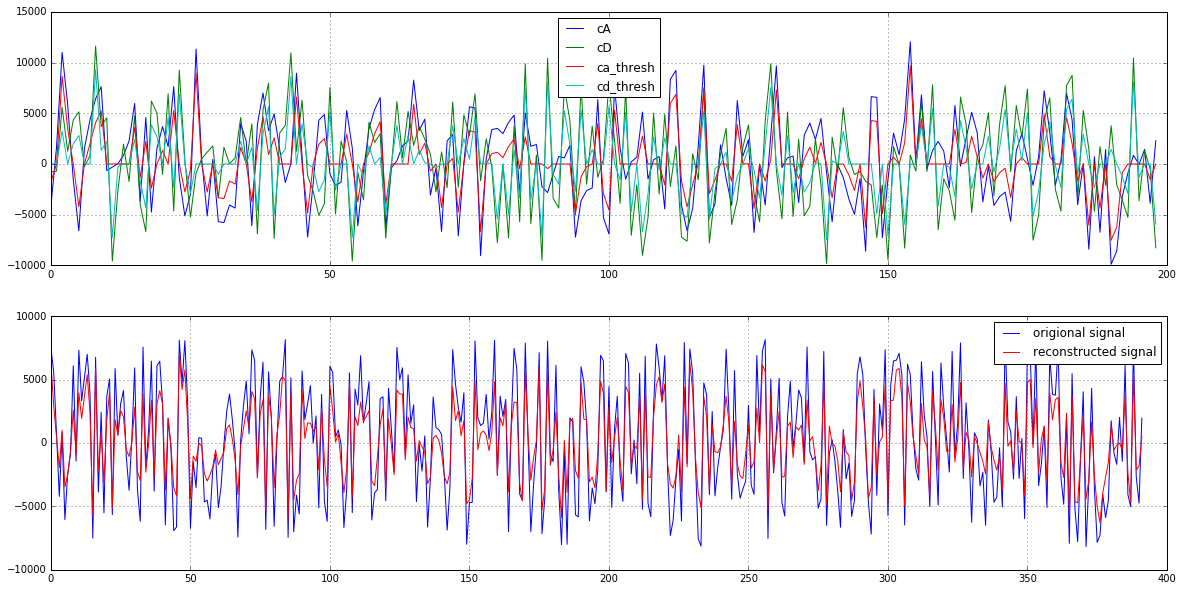

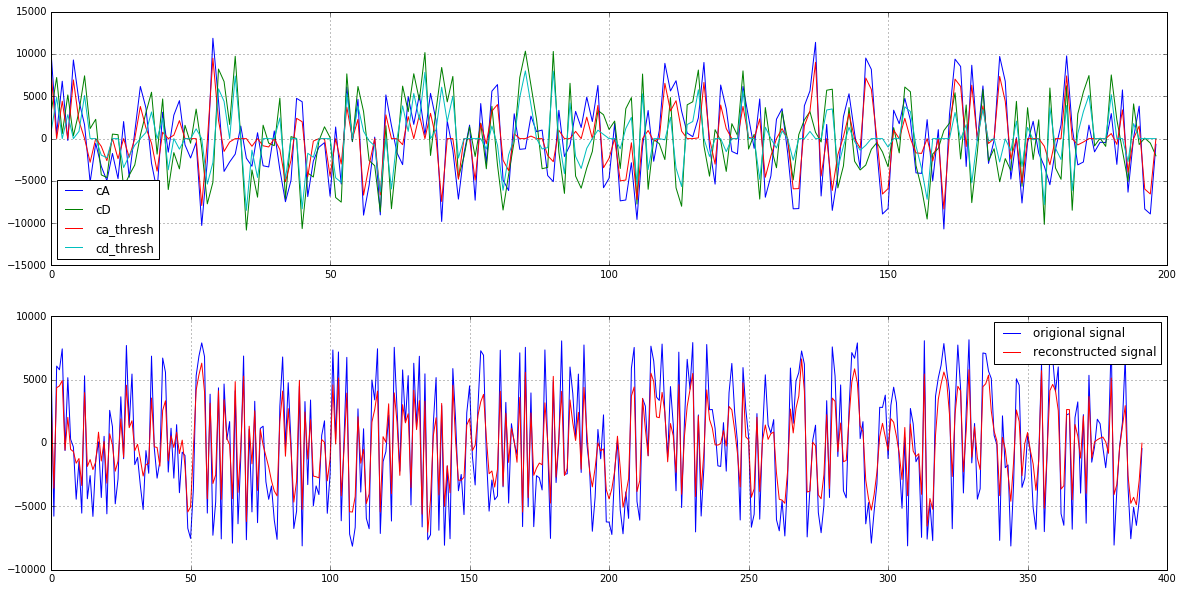

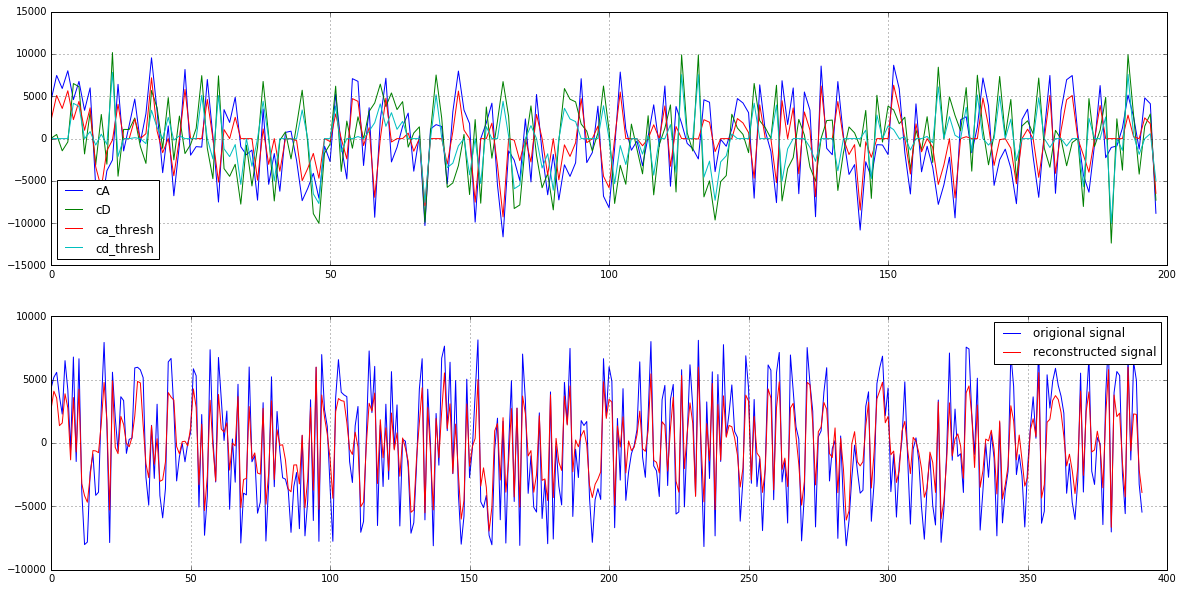

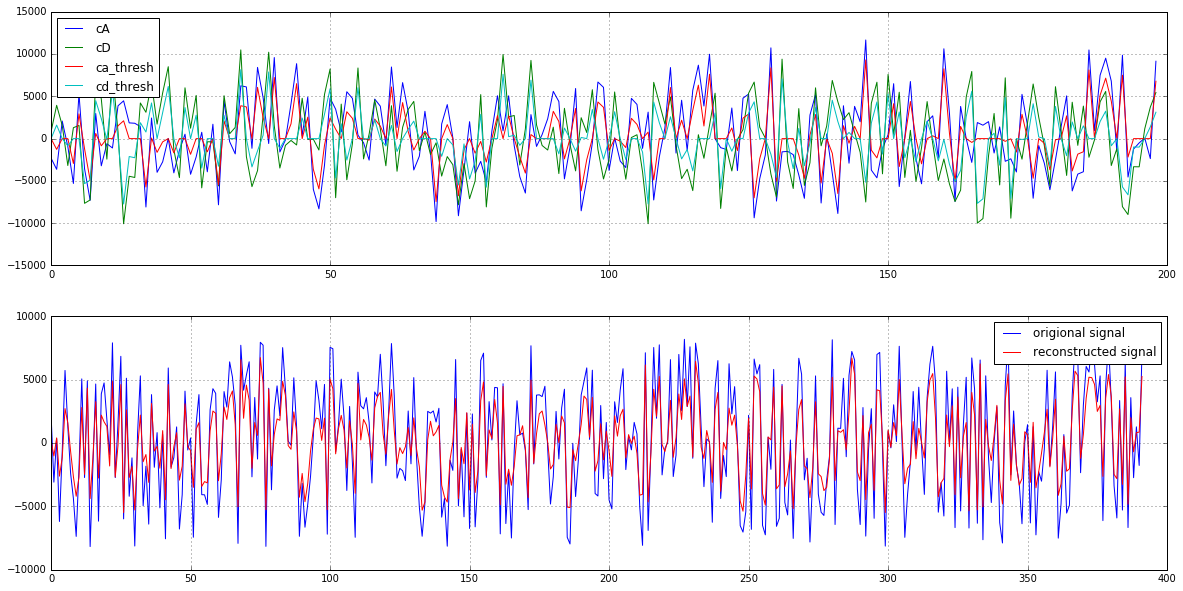

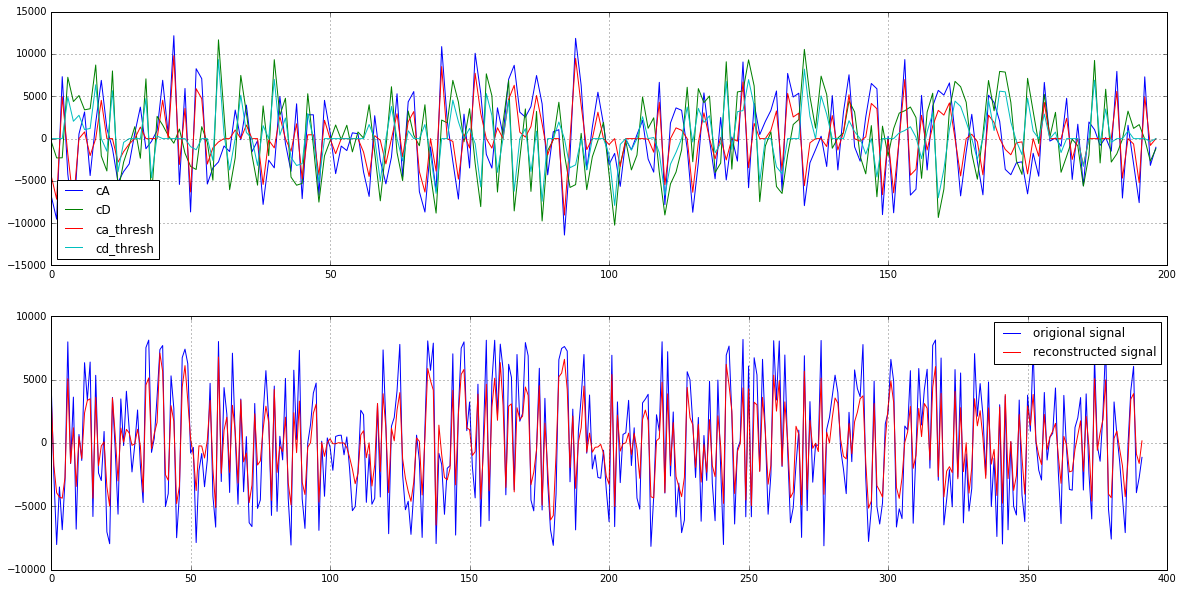

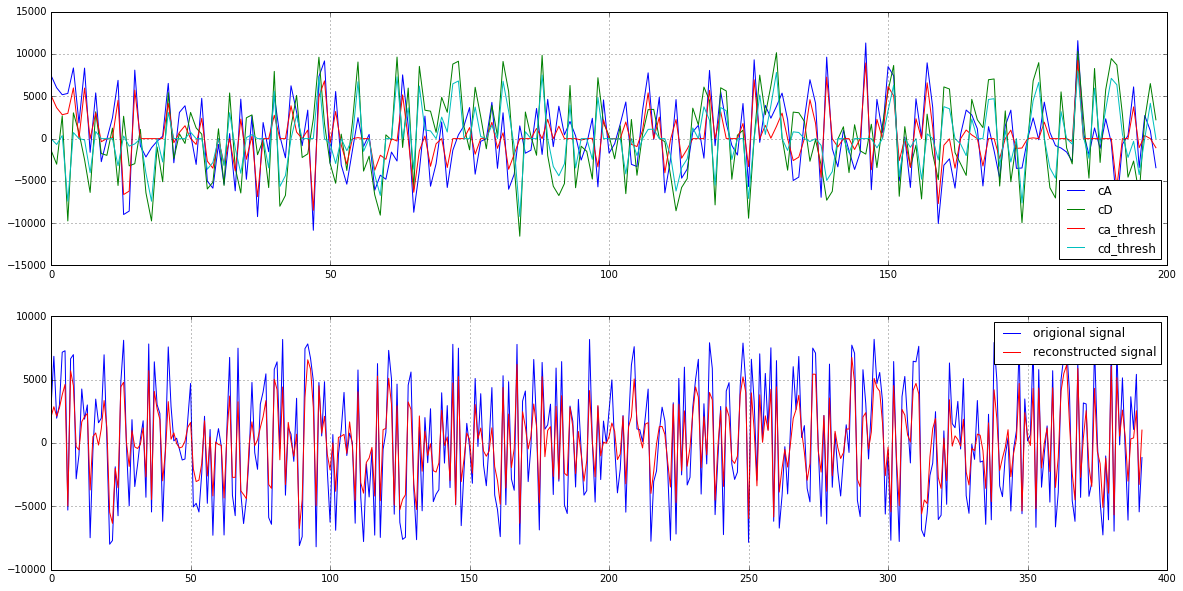

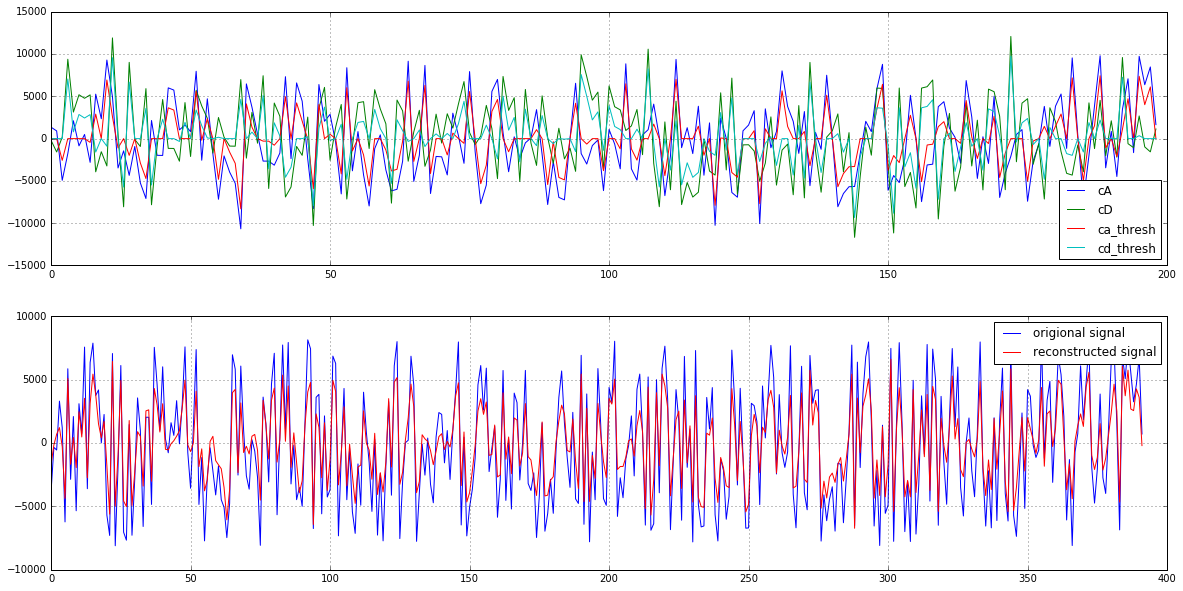

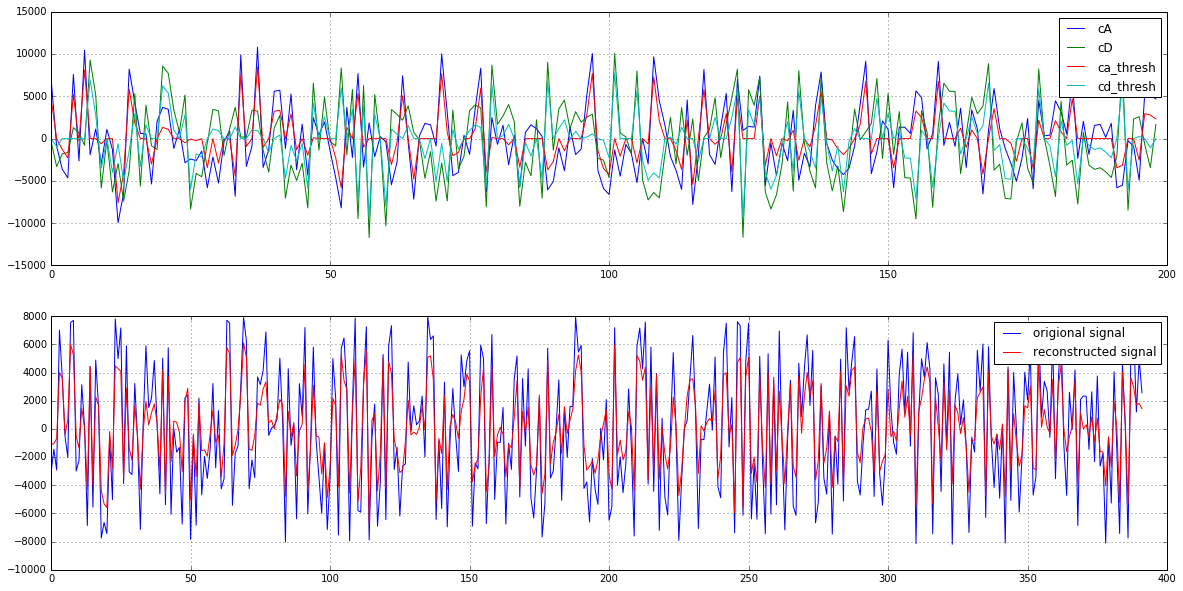

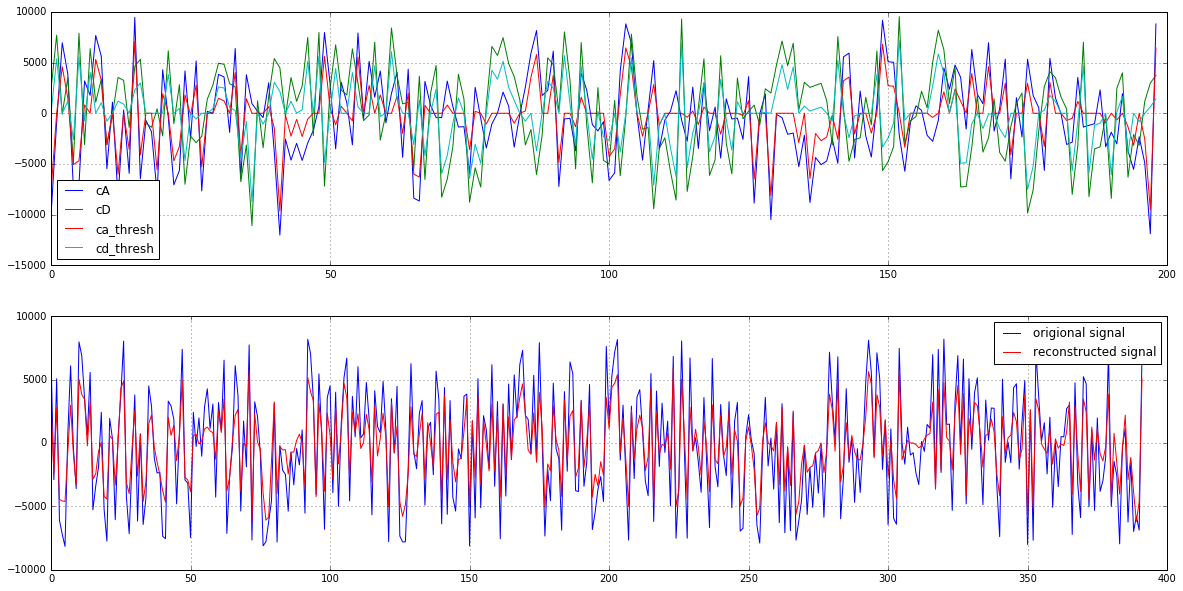

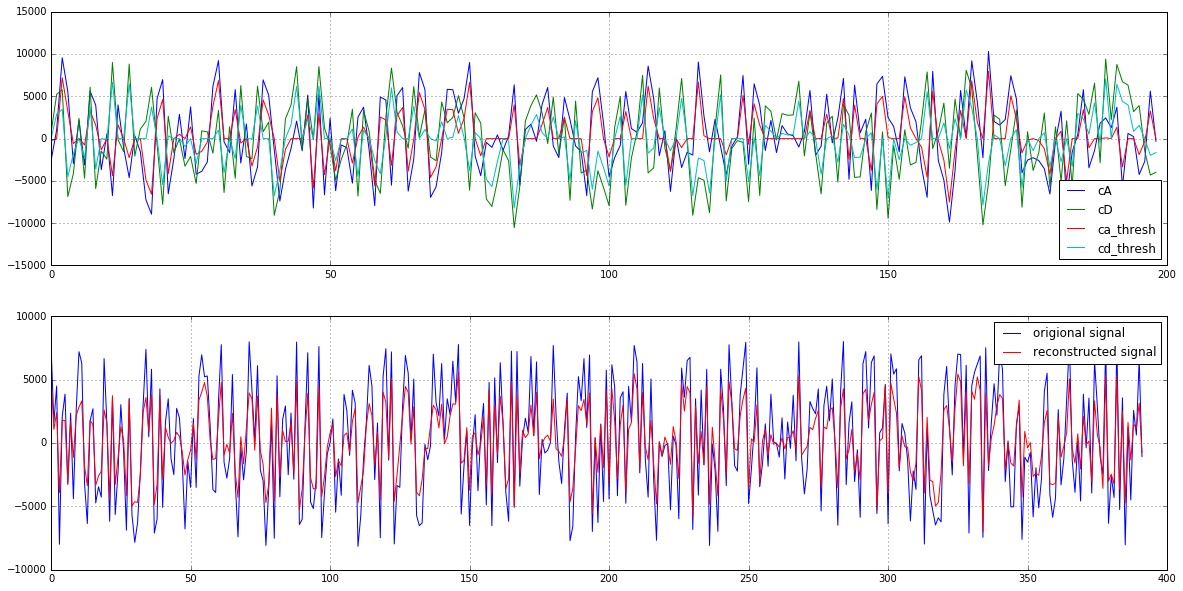

[[ 2853.20833388 -1133.25667432  5344.06475605 ...,   201.61276585
   2669.85800303 -1694.38597134]
 [-2410.40445585 -1032.50471633  1070.20839708 ..., -1023.03325551
   4082.28263199  -160.09340992]
 [ 2818.80314236  -695.09182502  2394.78667982 ...,   400.96484318
   3546.37807817   689.20287331]
 ..., 
 [-6190.9016634   1702.84282258  1156.44935235 ...,   813.53074042
   2253.93424144  4265.91213721]
 [-4631.30921603  1805.71290829  3133.34698006 ...,   858.53404869
  -2100.45711579  3596.35112944]
 [ 5059.78987234  1435.84064314  -758.1505055  ...,  5241.08566973
  -3899.13455236  -205.37549103]]


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import os
import glob
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
path = "./recording/raw_eeg"
filenames = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in filenames:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)


# drop the duplicates
emo_df = frame.drop_duplicates()
print emo_df
instances = emo_df.shape[0]

# set the sensor values
x = emo_df.ix[:,2:-1].values
y = emo_df['state']
size = y.shape[0]

# encode the text labels to allow for math opeartions
class_labels = np.unique(y)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


#reshape the class size for tensor operations
#y = y.reshape(size, 1)
print x
# align each sensor per row
x = x.T
labels = list(emo_df)
print labels
# extract the table labels
print x.shape
t = np.arange(0.0, instances, 1)
#t = np.arange(0.0, instances, 1)
fig, ax = plt.subplots(figsize=(20,10))
for i in x:
    ax.plot(i)
    ax.hold('on')

ax.set(xlabel='time(s)', ylabel='voltage (mV)',
       title='Raw EEG Signal')

ax.legend(labels[:-1])

ax.grid()

plt.show()

cA = []
cD = []
ts_rec = []
import pywt
for i in x:
    ca, cd = pywt.dwt(i, 'db4')
    cA.append(ca); cD.append(cd)

cat = pywt.thresholding.soft(cA, np.std(cA)/2)
cdt = pywt.thresholding.soft(cD, np.std(cD)/2)

for i, j in zip(cat, cdt):
    ts = pywt.idwt(i, j, 'db4')
    ts_rec.append(ts)
    
plt.close('all')
for i in range(14):
    plt.subplots(figsize=(20,10))
    
    plt.subplot(211)
    # Origional coefficients        
    plt.plot(cA[i])
    plt.plot(cD[i])
    # Thresholded coefficient
    plt.plot(cat[i])
    plt.plot(cdt[i])
    plt.legend(['cA', 'cD', 'ca_thresh', 'cd_thresh'], loc=0)
    plt.grid('on')
    
    plt.subplot(212)
    plt.plot(x[i])
    plt.hold('on')
    plt.plot(ts_rec[i], 'r')
    plt.legend(['origional signal', 'reconstructed signal'])
    plt.grid('on')
    plt.show()
    
from sklearn.cross_validation import train_test_split
import tensorflow as tf
signal_df = pd.DataFrame(
    {
    'F3': ts_rec[0],
    'F4': ts_rec[1],
    'P7': ts_rec[2],
    'FC6': ts_rec[3],
    'F7': ts_rec[4],
    'F8': ts_rec[5],
    'T7': ts_rec[6],
    'P8': ts_rec[7],
    'FC5': ts_rec[8],
    'AF4': ts_rec[9],
    'T8': ts_rec[10],
    '02': ts_rec[11],
    '01': ts_rec[12],
    'AF3': ts_rec[13]})

sig_matr = signal_df.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(sig_matr, y, test_size=0.25, random_state=0)

print sig_matr

# Data Processing

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#fit only to the training data 
scaler.fit(X_train)
# now for transforming the data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



In [17]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import GridSearchCV

polynomial_svm_clf = Pipeline((("poly_features", PolynomialFeatures(degree=3)),
            
                             ("svm_clf", LinearSVC(C=10, loss='hinge'))))

polynomial_svm_clf.fit(X_train, y_train)

params = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, params)
clf.fit(X_train, y_train)

svm_score = polynomial_svm_clf.score(X_test, y_test)
tuned_score = clf.score(X_test, y_test)
print("svm score:" + str(svm_score))
print("Tuned svm score:" + str(tuned_score))

svm score:0.428571428571
Tuned svm score:0.397959183673


In [18]:
# Decision trees
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier(criterion='entropy')
tree_clf.fit(X_train, y_train)

tree_score = tree_clf.score(X_test, y_test)

print ("Tree score:" + str(tree_score))



Tree score:0.469387755102
